# Redes recurrentes para datos secuenciales
En este ejemplo, utilizaremos redes recurrentes de distintos tipos para aprender un modelo de seguimiento vehicular. Definiéndolos de manera muy general, resumida y simplista, estos modelos buscan capturar el comportamiento de un conductor cuando se encuentra manejando detras de otro vehículo. Para este caso particular, utilizaremos datos provenientes de [ARED](https://ir.vanderbilt.edu/handle/1803/9358) (Arizona Ring Experiments Dataset), que nos entrega una secuencia de mediciones para cada uno de los vehículos participantes.

## 1. Importación de librerías
La importación es muy similar a los ejemplos que hemos visto anteriormente.

In [1]:
!pip install hiddenlayer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import hiddenlayer as hl
import tqdm
import pandas as pd
import time
#import matplotlib.pyplot as plt

## 2. Creación del set de datos
A diferencia de los casos anteriores, en este ejemplo crearemos una clase que además de entregar las facilidades de un `Dataset` que hemos visto antes, preprocese los datos para dejarlos listos para ser usados. El preprocesamiento se realiza en el método `create_sequences`, y recibe como parámetro un `DataFrame` de Pandas creado a partir de un archivo .csv.

Los datos se encuentran almacenados en el archivo `data.csv` en formato tabular, donde para cada vehículo se muestrean datos 30 veces por segundo. 

En particular, para cada observación (par [vehículo, instante de tiempo]) tendremos las variables `accel` (aceleración del vehículo), `speed` (velocidad del vehículo), `lead_speed` (velocidad del vehículo que se está siguiendo), y `gap` (tiempo transcurrido entre que el fin (parachoque trasero) del vehículo seguido y el inicio (parachoque delantero) del vehículo modelado pasan por un mismo punto). Como features (tensor `X`) utilizaremos `speed`, `lead_speed` y `gap`, mientras que como variable objetivo (vector `Y`) utilizaremos `accel`. 

Finalmente, y con el fin de tener los datos en el formato adecuado para una red recurrente, transformaremos la tabla de datos en un arreglo tridimensional con formato [obs,time_step,features], donde cada observación será ahora una secuencia de 2 _time steps_. Dado que originalmente cada fila almacena las variables para un par (vehículo, tiempo), para crear las secuencias concatenaremos cada fila con la fila inmediatamente siguiente y luego realizaremos un `reshape` del tensor para llevarlo de 2 a 3 dimensiones (los datos son los mismos, solo se reorganizan).

In [3]:
class RingDataset(Dataset):
  def __init__(self, path):
    self.data, self.X, self.Y = self.create_sequences(pd.read_csv(path, compression='xz'))
    self.X = torch.tensor(self.X)
    self.Y = torch.tensor(self.Y)
      
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]
  
  @staticmethod
  def create_sequences(data):
    # Transformamos los datos desde un arreglo con dos dimensiones [obs, features], 
    # a un arreglo tridimensional [obs,time_step,features]
    
    NUM_FEATURES = 3
    TIME_STEP = 2

    data = pd.concat([data[['speed', 'lead_speed', 'gap']], 
                      data[['speed', 'lead_speed', 'gap', 'accel', 'time']].shift(-1)], axis=1)             
    data.dropna(inplace=True)
    
    Y = data['accel'].values.astype('float32')
    X = data.drop(['accel', 'time'], axis=1).values
    X = X.reshape(X.shape[0], TIME_STEP, NUM_FEATURES).astype('float32')

    return data, X, Y

## 3. Creación del modelo
En este paso crearemos la red, utilizando inicialmente dos capas de RNN, donde cada una de estas es seguida de _dropout_ con probabilidad de 0.2. Luego de esto, tenemos una capa lineal final, que produce la predicción de la aceleración. Queda como modificación propuesta ver el efecto de cambiar el dropout y de agregar capas de _batch normalization_. Queda como ejercicio propuesto verificar los cambios de comportamiento al utilizar otro tipo de red recurrente.

Un detalle relevante es que en Pytorch las redes recurrenres (RNN, LSTM, GRU, etc), retornan la salida para cada paso de la secuencia (no solo para el final). Dado que en este caso solo nos interesa generar la predicción una vez que se procesa el último elemento de la secuencia, en el forward solo rescatamos la última columna del tensor `x` (`x[:,-1]`).

In [7]:
class TrafficNet(nn.Module):
  def __init__(self, input_size = 3, hidden_units = 128):
    super(TrafficNet, self).__init__()
    self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_units, 
                        num_layers = 2, batch_first = True, dropout = 0.2)
    self.dropout = nn.Dropout(p=0.2)
    self.linear = nn.Linear(hidden_units, 1)
      
  def forward(self, x):
    x, _ = self.rnn(x)
    x = self.dropout(x[:,-1])
    x = self.linear(x)
    return x.squeeze()

## 4. Carga de datos

In [9]:
training_set = RingDataset("data.csv")
params = {'batch_size': 2048,
          'num_workers': 1,
          'pin_memory': True}
data_loader = DataLoader(training_set, **params, shuffle = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrafficNet().to(device)

## 5. Entrenamiento

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

since = time.time()
history = hl.History()
history_train = hl.History()
canvas_train = hl.Canvas()

for epoch in range(num_epochs):
  start_epoch = time.time()
  epoch_loss = 0.0
  with tqdm.notebook.tqdm(total=len(data_loader), unit='batch', 
                          desc=f'Epoch {epoch+1}/{num_epochs}', position=100, leave=True) as pbar:                
    for i, (X, Y) in enumerate(data_loader):
      X = X.to(device)
      Y = Y.to(device)
      
      optimizer.zero_grad()
      Y_ = model(X) 
      loss = criterion(Y_, Y)                        
      loss.backward()                                
      optimizer.step()

      epoch_loss = (epoch_loss*i + loss.item())/(i+1)
      pbar.set_postfix(loss=epoch_loss)
      pbar.update()             
  epoch_elapsed = time.time() - start_epoch
  history_train.log(epoch, loss = epoch_loss)
  
time_elapsed = time.time() - since
print('Training complete in {:.0f}m'.format(time_elapsed/60))

Epoch 1/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 2/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 3/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 4/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 5/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 6/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 7/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 8/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 9/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 10/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 11/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 12/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 13/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 14/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 15/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 16/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 17/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 18/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 19/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 20/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 21/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 22/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 23/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 24/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 25/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 26/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 27/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 28/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 29/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 30/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 31/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 32/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 33/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 34/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 35/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 36/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 37/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 38/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 39/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 40/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 41/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 42/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 43/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 44/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 45/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 46/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 47/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 48/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 49/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Epoch 50/50:   0%|          | 0/666 [00:00<?, ?batch/s]

Training complete in 12m


# Plot

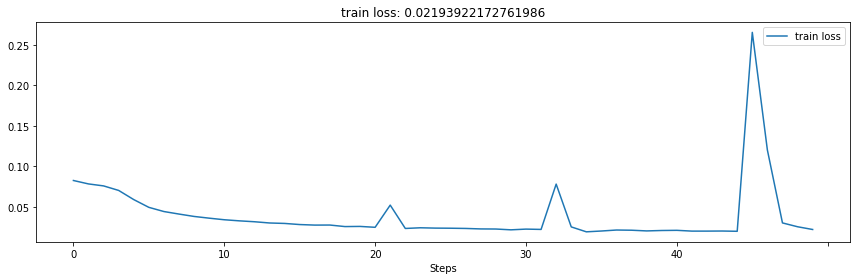

In [11]:
canvas =  hl.Canvas()
with canvas:
    canvas.draw_plot(history_train["loss"], labels=['train loss'])